This notebook aims to predict a diamond price using tabular regression. It contains two main parts: EDA and price prediction using the following dataset  https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices


In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from math import sqrt
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# import data
df = pd.read_csv(r'C:\Users\rootmerouane\Downloads\datasets\Diamonds Prices2022.csv')
display(df.shape)
df.head()

(53943, 11)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**EDA**

In [3]:
# drop irrelevant columns
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
# check  datatypes  (for instance the price can not be string )
df.dtypes.value_counts

<bound method Series.value_counts of carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object>

In [5]:
# check for rows duplicates and eliminate them
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)
df = df.drop_duplicates()
df.shape

('number of duplicate rows: ', (149, 10))


(53794, 10)

In [6]:
# check null values
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

**Our dataset does not contain NA values**

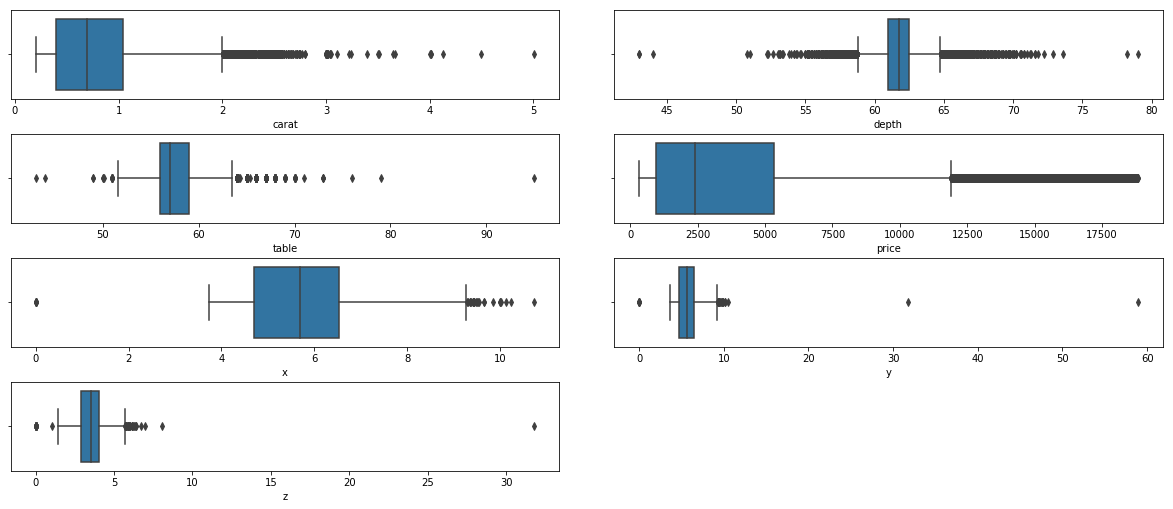

In [7]:
# check for outliers
num_features = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
plt.figure(figsize = (20,8))
for i,feature in enumerate(num_features):
    #fig, ax = plt.subplots(4,2,i+1)

    plt.subplot(4,2,i+1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
    sns.boxplot(x=df[feature])



**The boxplot shows the presence of some extreme outliers that can affect our training**

In [8]:
# Eliminate extreme outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df2 = df[~((df < (Q1 - 3 * IQR)) |(df > (Q3 + 3 * IQR))).any(axis=1)] #df without extreme outliers
display(df.shape)
display(df2.shape)

(53794, 10)

(53348, 10)

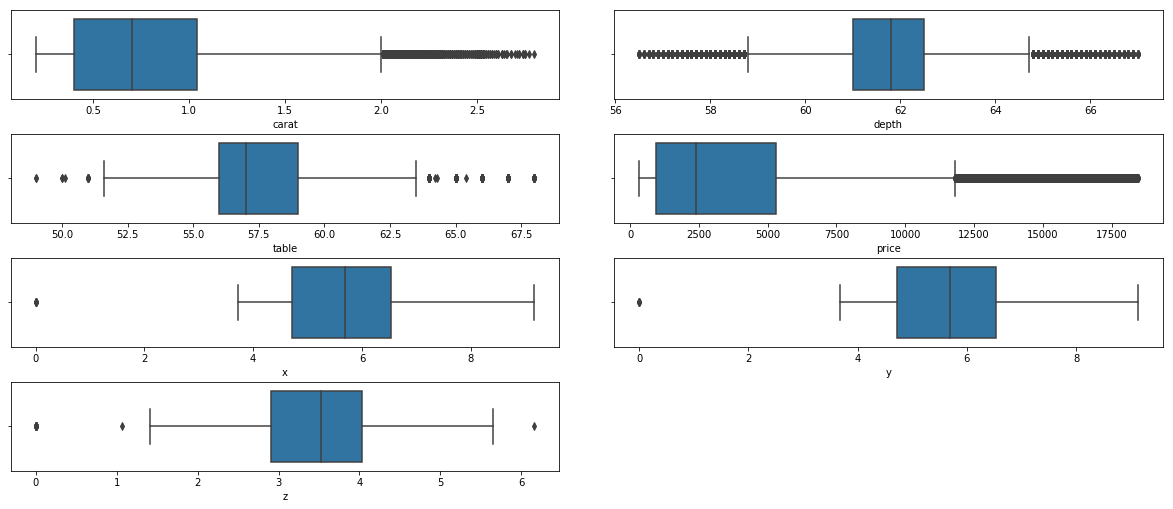

In [9]:
plt.figure(figsize = (20,8))
for i,feature in enumerate(num_features):
    #fig, ax = plt.subplots(4,2,i+1)

    plt.subplot(4,2,i+1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
    sns.boxplot(x=df2[feature])

In [10]:
display(df2.describe(include = 'all'))

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53348.000000,53348,53348,53348,53348.000000,53348.000000,53348.000000,53348.000000,53348.000000,53348.000000
unique,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,21443,11174,12934,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.792018,NaN,NaN,NaN,61.740834,57.439638,3894.551398,5.720585,5.723165,3.531245
std,0.464803,NaN,NaN,NaN,1.338839,2.193735,3928.217676,1.112137,1.104170,0.687776
min,0.200000,NaN,NaN,NaN,56.500000,49.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,NaN,NaN,NaN,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000
50%,0.700000,NaN,NaN,NaN,61.800000,57.000000,2394.000000,5.690000,5.700000,3.520000
75%,1.040000,NaN,NaN,NaN,62.500000,59.000000,5292.000000,6.530000,6.530000,4.030000


Text(0.5,0.98,'Countplots')

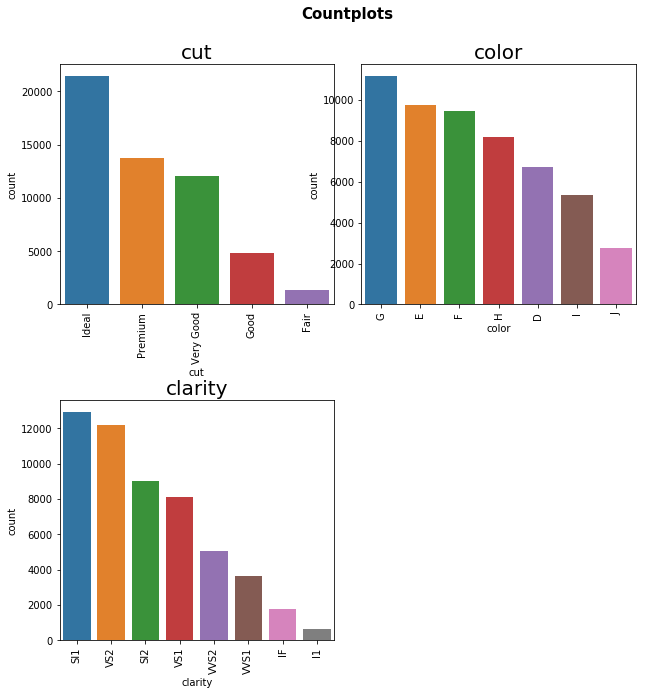

In [11]:
# count plot of categorical features
categorical = ['cut', 'color', 'clarity']
plt.figure(figsize=(10,10))
for i, feature in enumerate(categorical):
    plt.subplot(2,2,i+1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
    sns.countplot(data=df2, x=feature,order = df2[feature].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(feature,fontsize = 20)
    
plt.suptitle('Countplots',fontsize = 15,fontweight = 'bold')

No category has a negligble count.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D4F7BE0>,
      dtype=object)

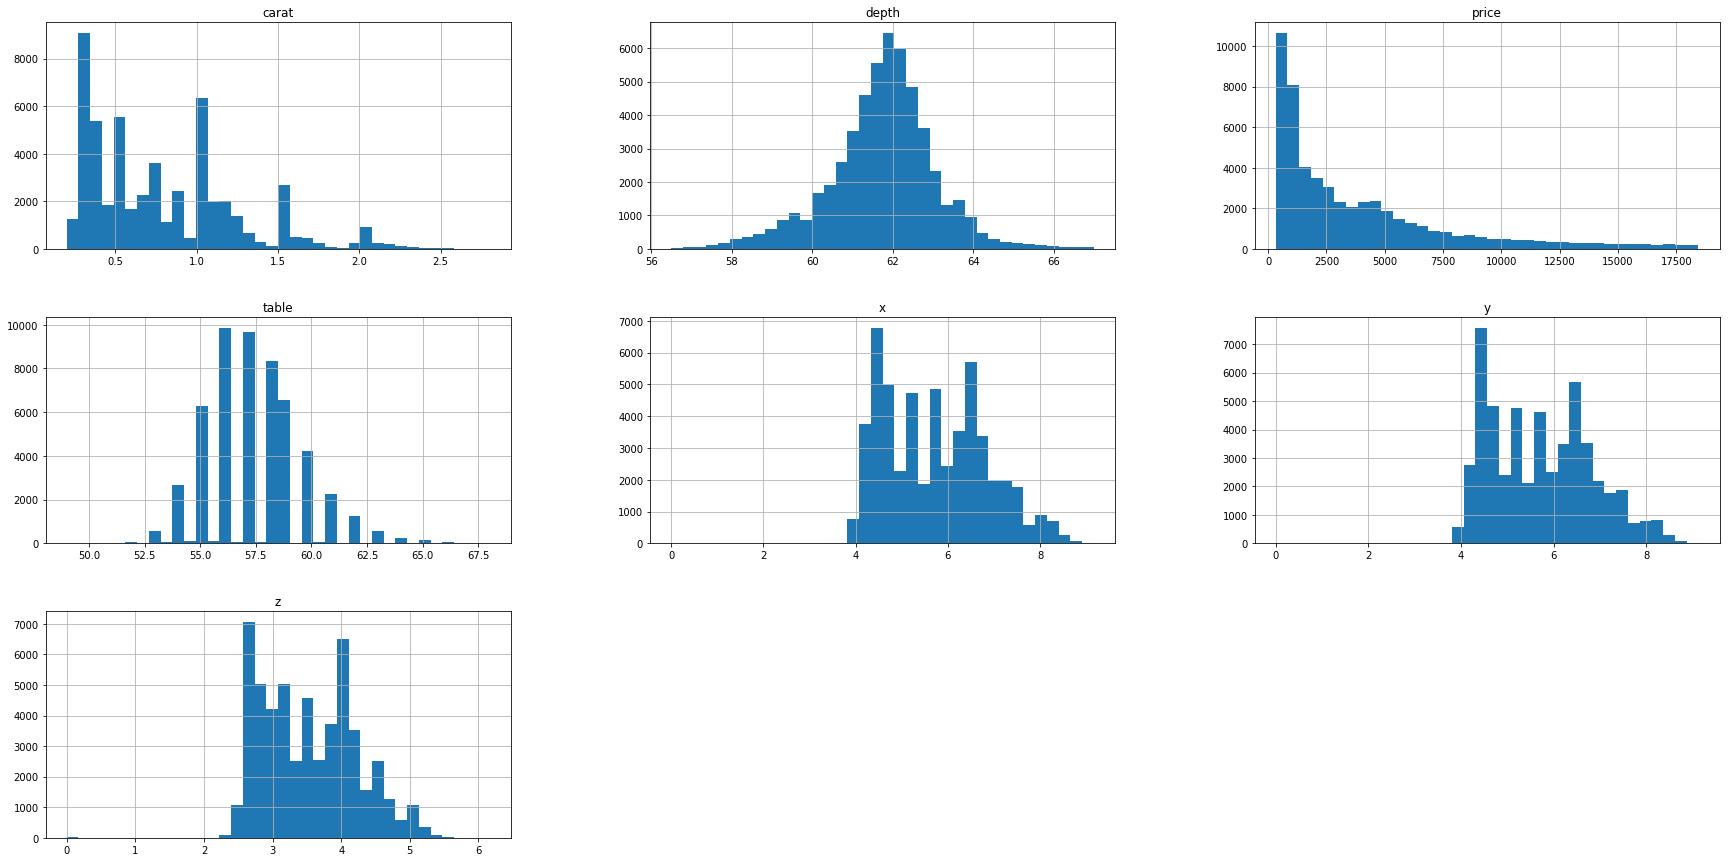

In [12]:
K = int(1 + 3.22 * np.log(df2.shape[0]))
df2.hist(bins=K,figsize=(30,15))

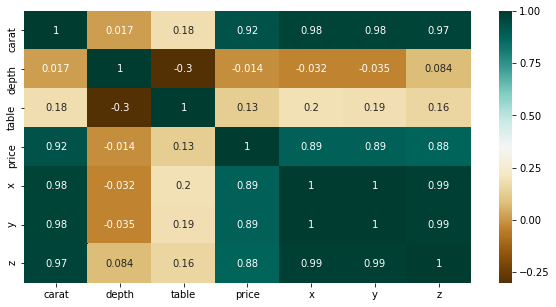

In [13]:
# Correlation between different features
plt.figure(figsize=(10,5))
c2= df2.corr()
sns.heatmap(c2,cmap="BrBG",annot=True)


- carat has the strongest correlation with the price
- x y and z are also highly correlated with the price
- table and depth has a weak correlation with the price
- carat, x, y and z are highly correlated with each other 

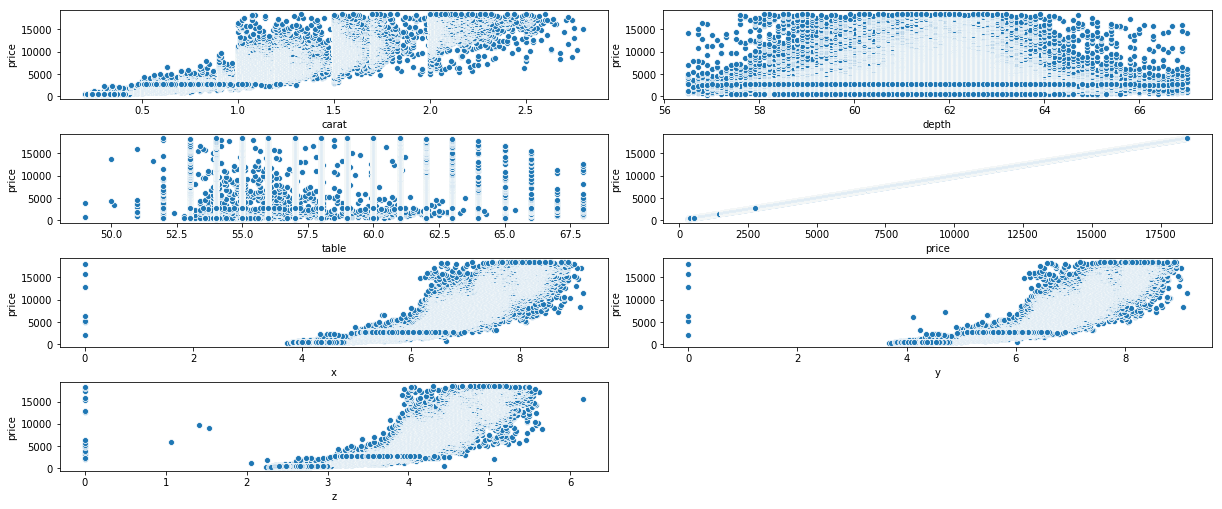

In [14]:
plt.figure(figsize = (20,8))
for i,feature in enumerate(num_features):
    plt.subplot(4,2,i+1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
    sns.scatterplot(x=df2[feature], y=df2['price'])  

In [15]:
# feature engineering
df2['ndepth'] = df2['depth']*df2['z']
df2['ntable'] = df2['table']*df2['x']*df2['y']
display(df2.corr()['price'])

carat     0.924751
depth    -0.013887
table     0.128891
price     1.000000
x         0.885496
y         0.887152
z         0.877527
ndepth    0.861027
ntable    0.902058
Name: price, dtype: float64

As we saw earlier with the correlation heat map, the variables 'depth' and 'table' have a very low correlaton with the price. Therefore,
we drop them during the training of our model and use the new created features 'ndepth' and 'ntable' instead. 

In [16]:
#PREPROCESSING
X = df2.drop(['price', 'table', 'depth'],axis=1)
Y = df2['price']
numerical = ['carat', 'ndepth', 'ntable', 'x', 'y', 'z']
categorical = ['clarity','color','cut']
categorical_processor = OrdinalEncoder()
numerical_processor = StandardScaler()
preprocessor = make_column_transformer(
    (categorical_processor, categorical),
    (numerical_processor, numerical),
)
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0)


In [17]:
def eval(model):
    model.fit(X_train,y_train)
    train_error = np.sqrt(mean_squared_error(model.predict(X_train),y_train))
    y_pred = model.predict(X_test)
    test_error = np.sqrt(mean_squared_error(y_pred,y_test))
    score = r2_score(y_test, y_pred)
    display('train error', train_error)
    display('test error', test_error)
    display('r2 score', score)
    N, trainscore,valscore = learning_curve(model, X_train,y_train,
                                            cv= 4, scoring = 'r2', train_sizes = np.linspace(0.1,1,10))
    plt.figure()
    plt.plot(N, trainscore.mean(axis = 1), label = 'train score')
    plt.plot(N, valscore.mean(axis = 1), label = 'val score')
    plt.legend()
    

In [18]:
# Random forest regressor
model = make_pipeline(preprocessor, RandomForestRegressor(random_state=0))

'train error'

232.1394219089321

'test error'

570.7477212816608

'r2 score'

0.9792630915582913

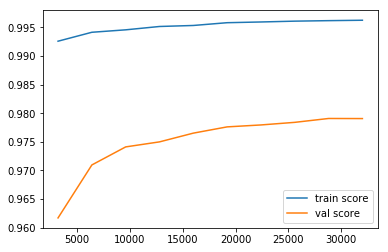

In [19]:
eval(model)

In [29]:
model = make_pipeline(preprocessor,PolynomialFeatures(2), RandomForestRegressor(random_state=0))

'train error'

235.58493617682552

'test error'

559.1500312834474

'r2 score'

0.9800972840537427

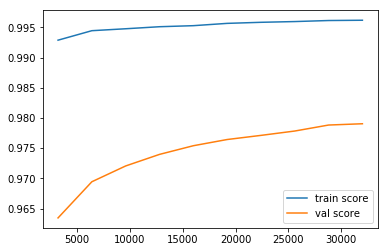

In [24]:
eval(model)

In [32]:
#Let's optimize this last model

params = {'randomforestregressor__max_features': [0.2,0.3,0.4,0.5],
          'randomforestregressor__n_estimators':[100,120,150,170]
         }
grid = RandomizedSearchCV(model,params, scoring = "neg_mean_squared_error",cv = 4,n_iter = 10)
grid.fit(X_train,y_train)
print(grid.best_params_)

{'randomforestregressor__n_estimators': 150, 'randomforestregressor__max_features': 0.5}


'train error'

195.99100451803528

'test error'

535.2846500714592

'r2 score'

0.9817599839148011

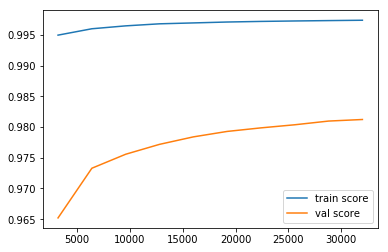

In [33]:
eval(grid.best_estimator_)

**Conclusion:**
The model is not overfitted.  The RandomForestRegrossr with 150 estimators and a 0.5 ratio of maximum features provides a high r2 score of 0.98. 

'train error'

240.8781673172109

'test error'

569.9144173194541

'r2 score'

0.9793236000198425

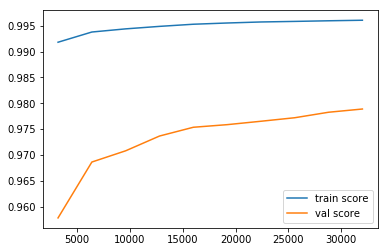

In [27]:
model = make_pipeline(preprocessor,PolynomialFeatures(4), RandomForestRegressor(random_state=0))
eval(model)

In [208]:
# learning model
X = df2.drop(['price', 'table', 'depth'],axis=1)
Y = df2['price']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=3)
numerical = ['carat', 'ndepth', 'ntable', 'x', 'y', 'z']
#, 'x', 'y', 'z'
categorical_features = X.columns.difference(numerical)
categorical_processor = OrdinalEncoder()
numerical_processor = StandardScaler()
preprocessor = make_column_transformer(
    (categorical_processor, categorical),
    (numerical_processor, numerical),
)
# linear regression
lin = make_pipeline(preprocessor, LinearRegression())
lin.fit(X_train,y_train)
y_pred = lin.predict(X_train)
train_rmse_lin = np.sqrt(mean_squared_error(y_pred,y_train))
y_pred = lin.predict(X_test)
test_rmse_lin = np.sqrt(mean_squared_error(y_pred,y_test))
score_lin = r2_score(y_test, y_pred)
display('lin train error', train_rmse_lin)
display('lin test error', test_rmse_lin)
display('lin r2 score', score_lin)
# decision tree regressor
tree = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
tree.fit(X_train,y_train)
y_pred = tree.predict(X_train)
train_rmse_tree = np.sqrt(mean_squared_error(y_pred,y_train))
y_pred = tree.predict(X_test)
test_rmse_tree = np.sqrt(mean_squared_error(y_pred,y_test))
score_tree = r2_score(y_test, y_pred)
display('tree train error', train_rmse_tree)
display('tree test error', test_rmse_tree)
display('tree r2 score', score_tree)

#random forest regressor
forest = make_pipeline(preprocessor, RandomForestRegressor(random_state=42))
forest.fit(X_train,y_train)
y_pred = forest.predict(X_train)
train_rmse_forest = np.sqrt(mean_squared_error(y_pred,y_train))
y_pred = forest.predict(X_test)
test_rmse_forest = np.sqrt(mean_squared_error(y_pred,y_test))
score_forest = r2_score(y_test, y_pred)
display('forest train error', train_rmse_forest)
display('forest test error', test_rmse_forest)
display('forest r2 score', score_forest)


'lin train error'

1286.8785687267014

'lin test error'

1275.0957473021444

'lin r2 score'

0.8911459943926071

'tree train error'

7.075039802008846

'tree test error'

723.5835536996607

'tree r2 score'

0.9649461119996116

'forest train error'

231.36395928319175

'forest test error'

554.5306805814487

'forest r2 score'

0.979412198178704

In [209]:
#gradient boosting regressor
GBR = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=42))
GBR.fit(X_train,y_train)
y_pred = GBR.predict(X_train)
train_rmse_GBR = np.sqrt(mean_squared_error(y_pred,y_train))
y_pred = GBR.predict(X_test)
test_rmse_GBR = np.sqrt(mean_squared_error(y_pred,y_test))
score_GBR = r2_score(y_test, y_pred)
display('GBR train error', train_rmse_GBR)
display('GBR test error', test_rmse_GBR)
display('GBR r2 score', score_GBR)


'GBR train error'

640.2470283636245

'GBR test error'

647.420608334297

'GBR r2 score'

0.9719371445488189

Text(0.5,1,'RMSE')

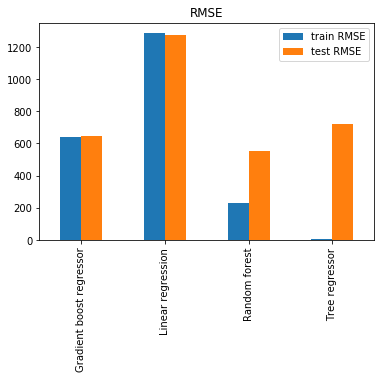

In [210]:
perf = {'Linear regression': [train_rmse_lin,test_rmse_lin,score_lin],'Tree regressor': [train_rmse_tree,test_rmse_tree,score_tree],
        'Random forest':[train_rmse_forest, test_rmse_forest,score_forest],'Gradient boost regressor':[train_rmse_GBR,test_rmse_GBR,score_GBR]}
perfdf = pd.DataFrame(perf)
perfdf = perfdf.T
perfdf.columns = ['train RMSE','test RMSE','R2 score']
perfdf[['train RMSE','test RMSE']].plot(kind='bar')   
plt.title('RMSE')

The decision tree and random forest regressors are overfitted.

The linear regressor is highly biased. 

In [189]:
# dealng with the overfittng problem of random forest regressor
# polynomial feat or regularization or CV  poly fet poly regresor cv 
df2['dim'] = df2['x']*df2['x']+df2['y']*df2['y']+df2['z']*df2['z']
X = df2.drop(['price', 'table', 'depth'],axis=1)
Y = df2['price']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=3)
numerical = ['carat', 'ndepth', 'ntable', 'dim']
categorical_features = ['cut', 'color', 'clarity']
#, 'x', 'y', 'z'
categorical_features = X.columns.difference(numerical)
categorical_processor = OrdinalEncoder()
numerical_processor = StandardScaler()
preprocessor = make_column_transformer(
    (categorical_processor, categorical),
    (numerical_processor, numerical),
)
forest = make_pipeline(preprocessor, RandomForestRegressor(random_state=42))
forest.fit(X_train,y_train)
y_pred = forest.predict(X_train)
train_rmse_forest = np.sqrt(mean_squared_error(y_pred,y_train))
y_pred = forest.predict(X_test)
test_rmse_forest = np.sqrt(mean_squared_error(y_pred,y_test))
score_forest = r2_score(y_test, y_pred)
display('forest train error', train_rmse_forest)
display('forest test error', test_rmse_forest)
display('forest r2 score', score_forest)

'forest train error'

233.7320532709592

'forest test error'

571.7816212372743

'forest r2 score'

0.9781113385704958

In [212]:
# Random forest CV
# learning model
X = df2.drop(['price', 'table', 'depth'],axis=1)
Y = df2['price']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=3)
numerical = ['carat', 'ndepth', 'ntable', 'x', 'y', 'z']
#, 'x', 'y', 'z'
categorical_features = X.columns.difference(numerical)
categorical_processor = OrdinalEncoder()
numerical_processor = StandardScaler()
preprocessor = make_column_transformer(
    (categorical_processor, categorical),
    (numerical_processor, numerical),
)
param_grid = {
  "n_estimators": [100,150,200], 
  "max_features": [2,4,6,8]
}

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg,param_grid,scoring="neg_mean_squared_error",return_train_score=True,cv=5)

forest = make_pipeline(preprocessor, grid_search)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_train)
train_rmse_forest = np.sqrt(mean_squared_error(y_pred,y_train))
y_pred = forest.predict(X_test)
test_rmse_forest = np.sqrt(mean_squared_error(y_pred,y_test))
score_forest = r2_score(y_test, y_pred)
display('forest train error', train_rmse_forest)
display('forest test error', test_rmse_forest)
display('forest r2 score', score_forest)

'forest train error'

196.56981691311472

'forest test error'

528.5129657991033

'forest r2 score'

0.9812987725382205

In [197]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 200}

In [198]:
# RGB CV
# learning model
X = df2.drop(['price', 'table', 'depth'],axis=1)
Y = df2['price']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=3)
numerical = ['carat', 'ndepth', 'ntable', 'x', 'y', 'z']
#, 'x', 'y', 'z'
categorical_features = X.columns.difference(numerical)
categorical_processor = OrdinalEncoder()
numerical_processor = StandardScaler()
preprocessor = make_column_transformer(
    (categorical_processor, categorical),
    (numerical_processor, numerical),
)
param_grid2={'n_estimators':[70,100,400], 
            'learning_rate': [0.1,0.05,0.2],
            'max_depth':[5,8,10], 
             } 

GBR_reg = GradientBoostingRegressor(random_state=42)
grid_search2 = GridSearchCV(GBR_reg,param_grid2,scoring="neg_mean_squared_error",return_train_score=True,cv=5)

GBR = make_pipeline(preprocessor, grid_search2)
GBR.fit(X_train,y_train)
y_pred = GBR.predict(X_train)
train_rmse_GBRCV = np.sqrt(mean_squared_error(y_pred,y_train))
y_pred = GBR.predict(X_test)
test_rmse_GBRCV = np.sqrt(mean_squared_error(y_pred,y_test))
display('GBR train error', train_rmse_GBRCV)
display('GBR test error', test_rmse_GBRCV)


'GBR train error'

281.9933369257512

'GBR test error'

517.5077653124641

NameError: name 'score_GBRCV' is not defined

In [211]:
Xnum = X[numerical]

poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(Xnum)
X_train,X_test,y_train,y_test = train_test_split(X_poly,Y,test_size=0.2,random_state=3)
pol_reg = LinearRegression()
pol_reg.fit(X_train, y_train)
y_pred = pol_reg.predict(X_train)
train_rmse_pol = np.sqrt(mean_squared_error(y_pred,y_train))
y_pred = pol_reg.predict(X_test)
test_rmse_pol = np.sqrt(mean_squared_error(y_pred,y_test))
score_pol = r2_score(y_test, y_pred)
display('pol train error', train_rmse_pol)
display('pol test error', test_rmse_pol)
display('pol r2 score', score_pol)

'pol train error'

1343.602909709543

'pol test error'

9326.537294160042

'pol r2 score'

-4.823709223568678